In [16]:
import numpy as np
import keras
from keras import layers
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from autograd import grad


In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(8, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def NN(data, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(data[['x','y']], data['label'], test_size=0.3, 
                                                        stratify = data['label'], random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 
    


In [57]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

In [58]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
#df1a = df1a.append(df1a_ood, ignore_index=True)
#df1a

In [20]:
# NN model
model = NN(df1a, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Epoch 1/15
12/12 [==============================] - 0s 21ms/step - loss: 1.0788 - accuracy: 0.3280 - val_loss: 0.9142 - val_accuracy: 0.3810
Epoch 2/15
12/12 [==============================] - 0s 4ms/step - loss: 0.8848 - accuracy: 0.4180 - val_loss: 0.7419 - val_accuracy: 0.6429
Epoch 3/15
12/12 [==============================] - 0s 5ms/step - loss: 0.7378 - accuracy: 0.6481 - val_loss: 0.6132 - val_accuracy: 0.7143
Epoch 4/15
12/12 [==============================] - 0s 6ms/step - loss: 0.6267 - accuracy: 0.7513 - val_loss: 0.5236 - val_accuracy: 0.8333
Epoch 5/15
12/12 [==============================] - 0s 5ms/step - loss: 0.5510 - accuracy: 0.8942 - val_loss: 0.4596 - val_accuracy: 0.9286
Epoch 6/15
12/12 [==============================] - 0s 5ms/step - loss: 0.4955 - accuracy: 0.9630 - val_loss: 0.4143 - val_accuracy: 0.9762
Epoch 7/15
12/12 [==============================] - 0s 3ms/step - loss: 0.4558 - accuracy: 0.9841 - val_los

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [22]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 2).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df1a[['x','y']].values))

$W \sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})$
$$\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right] = \log \left[\mathcal{N}(\mathbf{W}; 0, 5^2 \mathbf{I}) \prod_{n=1}^N softmax(WX^n)[y^n] \right]  = \log \left[  \prod_{n=1}^{D} \frac{1}{\sqrt{2\pi}5} \exp(-\frac{1}{2}(\frac{w_n}{5})^2) * \prod_{n=1}^N softmax(WX^n)[y^n]\right]  = \sum_{n=1}^{N} \log{(softmax(WX^n)[y^n])} + D* \log{\frac{1}{\sqrt{2\pi}5}} +(-\frac{1}{50} \sum_{n=1}^{D} w_n^2)$$

In [23]:
# HMC to calculate the posterior
import autograd.numpy as np
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df1a['label'].values
N = x.shape[0]

x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
def softmax1(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,None]
def log_posterior(W):

    V_ = softmax1(x_with_constant @ np.array(W).reshape((-1,nc)))
    term1 = sum([np.log(V_[i][int(y[i])]) for i in range(N)])
    term2 = D* np.log(1/(5*np.sqrt(2*np.pi))) -(1/50)*np.sum(W**2)
    return term1 + term2 

# The code is from class exercise 10.20

D = D #dim
m = 1 #mass
M = m * np.eye(D) #mass matrix

def U(W):
    return -log_posterior(W)
 
du_dy = grad(U) #gradient of U wrt to y

def K(p):
  # kinetic energy function
  return 0.5 * p.T @ np.linalg.inv(M) @ p + 0.5 * np.log(np.linalg.det(M)) + 0.5 * D * np.log(2 * np.pi)
dK_dp = grad(K) #gradient of K wrt p

def H(y, p):
  # H(y, p) = U(y) + K(p)
  return U(y) + K(p)

def HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning):
  # initialization
    samples = [y_init]
    y_current = y_init
    accept = 0
    for s in range(num_samples):
        # sample a random momentum from the Gibbs distribution of K(p), here is N(0,M)
        p_current = np.random.multivariate_normal(mean=np.zeros(D),cov=M)
        
        # leap-frog integrator
        y_next = y_current
        p_next = p_current
        p_next -= 0.5 * epsilon * np.array(du_dy(y_next)) #half-step update for momentum p 
        for j in range(int(num_steps)):
            y_next += epsilon * dK_dp(p_next) #full-step update for position y
            p_next -= epsilon * du_dy(y_next) #full-step update for momentum p 
        y_next += epsilon * dK_dp(p_next) #full-step update for position y
        p_next -= 0.5 * epsilon * du_dy(y_next) #half-step update for momentum p 

        # reverse momentum
        p_next = -p_next

        # correction for simulation error
        alpha = min(1, np.exp(H(y_current, p_current) - H(y_next, p_next)))
        if np.random.uniform(0, 1) <= alpha:
            y_current, p_current = y_next, p_next
            accept += 1
        samples.append(list(y_current))

    # burnin and thinning:
    samples = samples[burnin::thinning]
    return samples, accept/num_samples

y_init =np.array(list(model.layers[3].get_weights()[0].flatten())+list(model.layers[3].get_weights()[1].flatten()))
#y_init = np.ones((1,27)).flatten()
num_samples = 1000
num_steps = 50
epsilon = 1e-3 
burnin = int(num_samples*0.1)
thinning = 2


samples, accept = HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning)

In [24]:
fname = 'nlm_samples.npy'
np.save(fname,samples)
fnamen ='nlm_model'
model.save(fnamen)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: nlm_model/assets


In [53]:
def plot_graphs(samples,model):

    #create linespace
    x_linespace = np.linspace(-8, 8, 100)
    y_linespace = np.linspace(-8, 8, 100)
    dd_linespace = [[a, b] for a in x_linespace for b in y_linespace] 
    df_linespace = pd.DataFrame(dd_linespace,columns = ['x','y'])

    #construct feature space
    intermediate_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer(index = 2).output)


    linespace_output = np.array(intermediate_layer_model(df_linespace[['x','y']].values))
    linespace_withc = np.hstack((linespace_output,np.ones((linespace_output.shape[0],1),dtype = linespace_output.dtype)))

    #predict label for each point on linespace
    rand_samples = samples
    all_preds = []
    for W in rand_samples:
        V = softmax1(linespace_withc @ np.array(W).reshape((-1,nc)))
        all_preds.append(V)

    #assign predicted labels
    df_linespace['label'] = np.argmax(np.mean(all_preds,axis = 0),axis = 1)

    #assign uncertainty (using variance)
    mean_label = df_linespace['label']
    varss = np.var(all_preds,axis = 0)
    df_linespace['var']= [varss[i][mean_label[i]] for i in range(len(varss))]
    
    # mesh grid
    X, Y = np.meshgrid(x_linespace, y_linespace)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    plottt = df_linespace.pivot("y","x", "label")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Classifications')

    plt.subplot(1,2,2)
    plottt = df_linespace.pivot("y","x", "var")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Uncertainty')

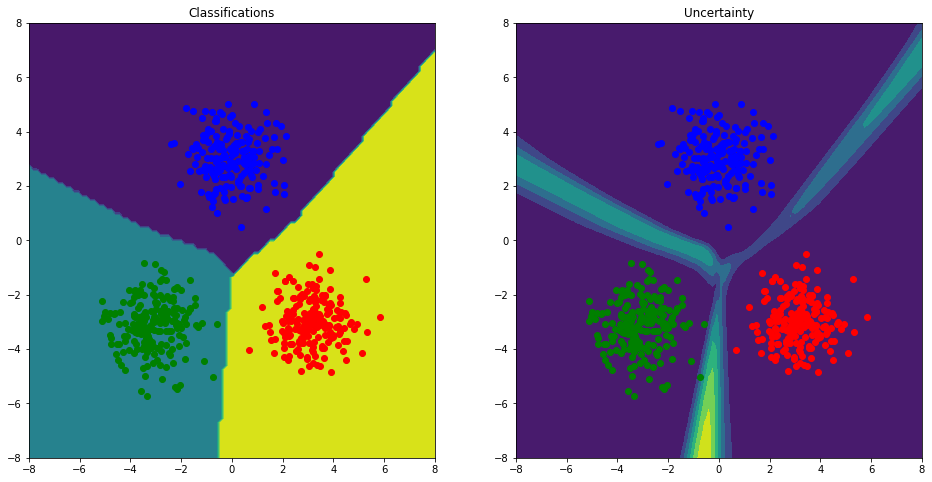

In [54]:
plot_graphs(samples,model)

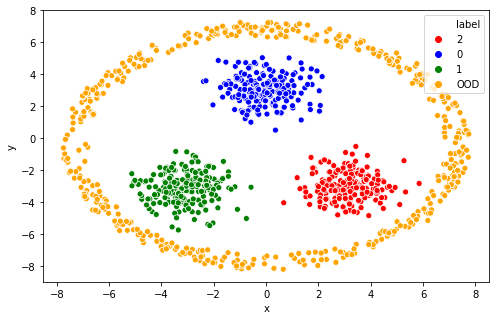

In [59]:
plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a.append(df1a_ood, ignore_index=True), x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);